#EECS 442/504 Final Project: Single Image Depth Estimation Using FPN

Jim Qian, Jiahang Li, Nan Chen

#**Acknowledgement**:
**This project is based on**

Paper: https://arxiv.org/pdf/1406.2283.pdf

Dataset: https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html

We upgraded this paper's architecture with FPN.

<br>

**Reference github 1 and 2 are used for their example of NYU dataset dataloaders.**

Reference github 1: https://github.com/zzzyq/Depth-Map-Prediction-with-Multi-Scale-Deep-network

Reference github 2:
https://github.com/imran3180/depth-map-prediction


**Reference github 3 is for architecture of the estimation network.**

Reference github 3: https://github.com/haofengac/MonoDepth-FPN-PyTorch

Reference github 4 (useful for the NYU datasetloaders): https://github.com/wolverinn/Depth-Estimation-PyTorch


# Using FPN to form backend structure and estimate depth 

In [1]:
#install some python modules we need
!pip -q install wget
!pip -q install gdown

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data._utils.collate import default_collate
from torch import optim
from torchvision import transforms
import torchvision
from torchvision import models
from torchvision.models import feature_extraction
from torchvision.ops import sigmoid_focal_loss,nms

import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'
import matplotlib
import torch
from PIL import Image

from typing import Optional, Dict, List, Optional, Tuple
import wget
import gdown
import json
import random
import tarfile
import time
import shutil


In [3]:
# check GPU
if torch.cuda.is_available():
    print("Using the GPU!")
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

Using the GPU!


In [4]:
# for plotting
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

## Load dataset for mat format
(This part can be skipped as we use another way to process NYUV2 dataset) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download NYU dataset
<br>
Each RGB image is 3x640x480.
<br>
Each depth image is 1x640x480.
<br>
Transformation: don't need to resize; need ToTensor() and Normalize(mean, std)

In [ ]:
# load dataset
import h5py
images= h5py.File('/content/drive/Shared drives/CV_Final_project/nyu_depth_v2_labeled.mat')

image_data=images['images']
print(image_data.shape)

image_depths=images['depths']
print(image_depths.shape)
print(type(image_depths))


(1449, 3, 640, 480)
(1449, 640, 480)
<class 'h5py._hl.dataset.Dataset'>


In [ ]:
from torch.utils.data import DataLoader
train_img_data = image_data[0:868]
# valid_img_data = image_data[869:1158]
# test_img_data = image_data[1159:1448]

# train_depth = image_depths[0:868]
# valid_depth = image_depths[869:1158]
# test_depth = image_depths[1159:1448]

train_img_loader = DataLoader(train_img_data, shuffle=False, num_workers=1)


# train_dataset = datasets.ImageFolder(data_dir, composed_transform)[0:868]
# valid_dataset = datasets.ImageFolder(data_dir, composed_transform)[869:1158]
# test_dataset = datasets.ImageFolder(data_dir, composed_transform)[1159:1448]

##Use FPN backbone to estimate Depth
(This part can also be skipped beacause it deal with dataset with mat format)

In [ ]:
from torchvision.models.resnet import resnet50

def down_conv(dim_in, dim_out):
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_in, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

def smooth(dim_in, dim_out):
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

def final_conv(dim_in, dim_out):
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid(),
    )

def upshuffle(dim_in, dim_out, upscale_factor):
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_out*upscale_factor**2, kernel_size=3, stride=1, padding=1),
        nn.PixelShuffle(upscale_factor),
        nn.ReLU()
    )


class DepthEestimation(nn.Module):
    def __init__(self, weights='ResNet50_Weights.DEFAULT', freeze_weight=False):
        super(DepthEestimation, self).__init__()

        resnet = resnet50(weights = weights)

        # Freeze those weights
        if freeze_weight:
            for p in resnet.parameters():
                p.requires_grad = False

        # resnet _forward_impl operation
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = nn.Sequential(resnet.layer1)
        self.layer2 = nn.Sequential(resnet.layer2)
        self.layer3 = nn.Sequential(resnet.layer3)
        self.layer4 = nn.Sequential(resnet.layer4)

        # Top layer
        self.toplayer = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Lateral layers
        self.latlayer1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d( 512, 256, kernel_size=1, stride=1, padding=0)

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)


        # # Aggregate layers
        self.down1 = down_conv(256, 128)
        self.down2 = down_conv(256, 128)
        self.down3 = down_conv(256, 128)
        
        # # Upshuffle layers
        self.up1 = upshuffle(128,128,8)
        self.up2 = upshuffle(128,128,4)
        self.up3 = upshuffle(128,128,2)
        
        # last two conv for Depth prediction
        self.conv1 = conv1(384, 64)
        self.conv2 = final_conv(64, 1)
        
    def upsample_add(self, x, y):
        '''Upsample and add feature maps.
        used bilinear mode to make sure
        the layers have same size
        '''
        _,_,H,W = y.size()
        return nn.functional.interpolate(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        _,_, H, W = x.size()
        
        # Bottom-up
        c1 = self.layer0(x)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        # Top-down
        p5 = self.toplayer(c5)
        p4 = self.upsample_add(p5, self.latlayer1(c4))
        p4 = self.smooth1(p4)
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p3 = self.smooth2(p3) 
        
        # upshuffle and combine p3,p4,p5, process to the final prediction
        p5_shuffle, p4_shuffle, p3_shuffle = self.up1(self.down1(p5)), self.up2(self.down2(p4)), self.up3(self.down3(p3))
        _, _, H, W = d3.size()
        feat = torch.cat( [ nn.functional.interpolate(p, size=(H,W), mode='bilinear') for p in [p5_shuffle, p4_shuffle, p3_shuffle] ], dim=1 )
        return self.conv2( self.conv1(feat) )   

test for the estimation model

In [ ]:
i2d =  DepthEestimation()
i = True

for img in train_img_loader:
  while i:     
    print(img.size())
    z_fake = i2d(img.float())
    print(z_fake)
    print(z_fake.size())
    i = False

In [ ]:
print(images.keys())
print(images['rawDepths'])

##Training using NYUv2Datasetloader

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from torchvision.models.resnet import resnet101
import torch.utils.data as data
from PIL import Image
from torchvision.transforms import Resize, Compose, ToPILImage, ToTensor
import pickle

LOAD_DIR = "/content/drive/Shared drives/CV_Final_project"

class NYUv2Dataset(data.Dataset):
    def __init__(self, train=True):
        self.load_type = "train" if train else "test"
        if train:
            self.index_pkl = pickle.load(open("{}/data/index1.pkl".format(LOAD_DIR),'rb'))
            self.rgb_paths = list(self.index_pkl.keys())
        else:
            self.index_pkl = pickle.load(open("{}/data/index2.pkl".format(LOAD_DIR),'rb'))
            self.rgb_paths = list(self.index_pkl.keys())
        self.rgb_transform = Compose([ToTensor()]) 
        self.depth_transform = Compose([ToTensor()])
        self.length = len(self.rgb_paths)
            
    def __getitem__(self, index):
        path = '{}/data/{}_rgb/'.format(LOAD_DIR,self.load_type)+self.rgb_paths[index]
        rgb = Image.open(path)
        depth = Image.open('{}/data/{}_depth/'.format(LOAD_DIR,self.load_type)+self.index_pkl[self.rgb_paths[index]])
        depth = depth.resize((160,120))
        return self.rgb_transform(rgb).float(), self.depth_transform(depth).float()

    def __len__(self):
        return self.length

def imgrad(img):
    img = torch.mean(img, 1, True)
    fx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
    weight = torch.from_numpy(fx).float().unsqueeze(0).unsqueeze(0)
    if img.is_cuda:
        weight = weight.cuda()
    conv1.weight = nn.Parameter(weight)
    grad_x = conv1(img)
    # grad y
    fy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
    weight = torch.from_numpy(fy).float().unsqueeze(0).unsqueeze(0)
    if img.is_cuda:
        weight = weight.cuda()
    conv2.weight = nn.Parameter(weight)
    grad_y = conv2(img)
    return grad_y, grad_x

def imgrad_yx(img):
    N,C,_,_ = img.size()
    grad_y, grad_x = imgrad(img)
    return torch.cat((grad_y.view(N,C,-1), grad_x.view(N,C,-1)), dim=1)



Loss functions

In [10]:
class GradLoss(nn.Module):
    def __init__(self):
        super(GradLoss, self).__init__()
    # L1 norm
    def forward(self, pred, gt):
        return torch.mean( torch.abs(gt - pred) )

class RMSE_log(nn.Module):
    def __init__(self):
        super(RMSE_log, self).__init__()
    
    def forward(self, pred, gt):
        if not pred.shape == gt.shape:
            _, _, H, W = gt.shape
            pred = F.upsample(pred, size=(H,W), mode='bilinear')
        loss = torch.sqrt( torch.mean( torch.abs(torch.log(gt) - torch.log(pred)) ** 2 ) )
        return loss

class NormalLoss(nn.Module):
    def __init__(self):
        super(NormalLoss, self).__init__()
    
    def forward(self, grad_pred, grad_gt):
        product = ( grad_pred[:,:,None,:] @ grad_gt[:,:,:,None] ).squeeze(-1).squeeze(-1)
        norm_pred = torch.sqrt( torch.sum( grad_pred**2, dim=-1 ) )
        norm_gt = torch.sqrt( torch.sum( grad_gt**2, dim=-1 ) )
        
        return 1 - torch.mean( product / (norm_pred * norm_gt) )

class Evl_loss(nn.Module):
    def __init__(self):
        super(Evl_loss, self).__init__()
    
    def forward(self, pred, gt):
        if not pred.shape == gt.shape:
            _, _, H, W = gt.shape
            pred = F.upsample(pred, size=(H,W), mode='bilinear')
        loss = torch.sqrt( torch.mean( torch.abs(10.*gt - 10.*pred) ** 2 ) )
        loss /= 10000 
        return loss

Depth estimation model

In [12]:
from torchvision.models.resnet import resnet101

def down_conv(dim_in, dim_out):
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_in, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

def conv1(dim_in, dim_out):
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

def final_conv(dim_in, dim_out):
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

def upshuffle(dim_in, dim_out, upscale_factor):
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_out*upscale_factor**2, kernel_size=3, stride=1, padding=1),
        nn.PixelShuffle(upscale_factor),
        nn.ReLU()
    )

class DepthEestimation(nn.Module):
    def __init__(self, weights='ResNet101_Weights.DEFAULT', freeze_weight=False):
        super(DepthEestimation, self).__init__()

        resnet = resnet101(weights = weights)

        # Freeze those weights
        if freeze_weight:
            for p in resnet.parameters():
                p.requires_grad = False

        # resnet _forward_impl operation
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = nn.Sequential(resnet.layer1)
        self.layer2 = nn.Sequential(resnet.layer2)
        self.layer3 = nn.Sequential(resnet.layer3)
        self.layer4 = nn.Sequential(resnet.layer4)

        # Top layer
        self.toplayer = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Lateral layers
        self.latlayer1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d( 512, 256, kernel_size=1, stride=1, padding=0)

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)


        # # Aggregate layers
        self.down1 = down_conv(256, 128)
        self.down2 = down_conv(256, 128)
        self.down3 = down_conv(256, 128)
        
        # # Upshuffle layers
        self.up1 = upshuffle(128,128,8)
        self.up2 = upshuffle(128,128,4)
        self.up3 = upshuffle(128,128,2)
        
        # last two conv for Depth prediction
        self.conv1 = conv1(384, 64)
        self.conv2 = final_conv(64, 1)
        
    def upsample_add(self, x, y):
        '''Upsample and add feature maps.
        used bilinear mode to make sure
        the layers have same size
        '''
        _,_,H,W = y.size()
        return nn.functional.interpolate(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        _,_, H, W = x.size()
        
        # Bottom-up
        c1 = self.layer0(x)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        # Top-down
        p5 = self.toplayer(c5)
        p4 = self.upsample_add(p5, self.latlayer1(c4))
        p4 = self.smooth1(p4)
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p3 = self.smooth2(p3) 
        
        # upshuffle and combine p3,p4,p5, process to the final prediction
        p5_shuffle, p4_shuffle, p3_shuffle = self.up1(self.down1(p5)), self.up2(self.down2(p4)), self.up3(self.down3(p3))
        _, _, H, W = p3_shuffle.size()
        feat = torch.cat( [ nn.functional.interpolate(p, size=(H,W), mode='bilinear') for p in [p5_shuffle, p4_shuffle, p3_shuffle] ], dim=1 )
        return self.conv2( self.conv1(feat) )    

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# learning rate and batch size
lr = 0.001
bs = 4
# dataset
train_dataset = NYUv2Dataset()
train_size = len(train_dataset)
eval_dataset = NYUv2Dataset(train=False)
print("The length of the training dataset is {}.".format(train_size))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs,shuffle=True)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=bs,shuffle=True)
i2d =  DepthEestimation()
i2d = i2d.to(DEVICE)


# load model
try:
    i2d.load_state_dict(torch.load('{}/fpn_model.pt'.format(LOAD_DIR),map_location='cpu'))
    print("Depth Eestimation model loaded")
except:
    print("model load failed")


# optimizer
optimizer = torch.optim.Adam(i2d.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=4e-5)

# loss function
grad_criterion = GradLoss()
depth_criterion = RMSE_log()
normal_criterion = NormalLoss()
evl_loss = Evl_loss()
# report loss step
lrs = 20
# report validation loss epoch
vle = 1
# max epoch
max_epoch = 1

# start training
for epoch in range(0, max_epoch):
    try:
        torch.cuda.empty_cache()
    except:
        pass
    i2d.train()
    start = time.time()
    # learning rate decay
    if epoch > 5:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.9
    for i, (img, depth) in enumerate(train_dataloader):
        img, depth = img.to(DEVICE), depth.to(DEVICE)
        optimizer.zero_grad()
        depth_pred = i2d(img)
        grad_gt, grad_pred = imgrad_yx(depth), imgrad_yx(depth_pred)
        grad_loss = grad_criterion(grad_gt, grad_pred)
        # depth_loss = depth_criterion(z, z_fake)
        normal_loss = normal_criterion(grad_gt, grad_pred)
        loss = grad_loss + normal_loss
        loss.backward()
        optimizer.step()
        if (i+1) % (lrs) == 0:
            print("[epoch %2d][iter %4d] loss: %.4f" % (epoch+1, i+1, loss))
    # save model
    torch.save(i2d.state_dict(),'{}/fpn_model.pt'.format(LOAD_DIR))

    # Validation
    if (epoch+1) % vle == 0:
        try:
            torch.cuda.empty_cache()
        except:
            pass
        i2d.eval()
        print('evaluating mean loss using Evl_loss function:')
        eval_loss = 0
        count = 0
        with torch.no_grad():
          for i,(img, z) in enumerate(eval_dataloader):
              img, z = img.to(DEVICE), z.to(DEVICE)
              z_pred = i2d(img)
              eval_loss += float(img.size(0)) * evl_loss(z_pred, z).item()**2
              count += float(img.size(0))
        print("[epoch %2d] val_loss: %.4f" % (epoch+1, math.sqrt(eval_loss/count)))

    end = time.time()
    print('model saved and validate the loss in validation dataset')
    print('time elapsed: %fs' % (end - start))

The length of the training dataset is 1354.
Depth Eestimation model loaded
[epoch  1][iter   20] loss: 4816.3218
[epoch  1][iter   40] loss: 5343.0352
[epoch  1][iter   60] loss: 4459.5962
[epoch  1][iter   80] loss: 4235.3062
[epoch  1][iter  100] loss: 4447.4155
[epoch  1][iter  120] loss: 4083.2727
[epoch  1][iter  140] loss: 3988.4226
[epoch  1][iter  160] loss: 5482.8115
[epoch  1][iter  180] loss: 2833.1106
[epoch  1][iter  200] loss: 4507.8545
[epoch  1][iter  220] loss: 3469.8247
[epoch  1][iter  240] loss: 4375.5029
[epoch  1][iter  260] loss: 4114.7983
[epoch  1][iter  280] loss: 3437.9958
[epoch  1][iter  300] loss: 4829.2388
[epoch  1][iter  320] loss: 4827.1748
evaluating mean loss using Evl_loss function:
[epoch  1] val_loss: 4.8607
model saved and validate the loss in validation dataset
time elapsed: 1202.317189s


##Evaluation

In [14]:
from torchvision import transforms
import math
import matplotlib.pyplot as plt

In [15]:
# Evaluation datasetloader

LOAD_DIR = "/content/drive/Shared drives/CV_Final_project"
LOAD_TYPE = "evl"
class NYU2Dataset(data.Dataset):
    def __init__(self):
        self.index_pkl = pickle.load(open("{}/nyu2/index.pkl".format(LOAD_DIR),'rb'))
        self.rgb_paths = list(self.index_pkl.keys())
        self.rgb_transform = Compose([ToTensor()])
        self.depth_transform = Compose([ToTensor()])
        self.length = len(self.rgb_paths)
            
    def __getitem__(self, index):
        path = '{}/nyu2/{}_rgb/'.format(LOAD_DIR,LOAD_TYPE)+self.rgb_paths[index]
        rgb = Image.open(path)
        depth = Image.open('{}/nyu2/{}_depth/'.format(LOAD_DIR,LOAD_TYPE)+self.index_pkl[self.rgb_paths[index]])
        depth = depth.resize((160,120))
        return self.rgb_transform(rgb).float(), self.depth_transform(depth).float()

    def __len__(self):
        return self.length



In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eval_dataset = NYU2Dataset()
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=1,shuffle=True)
i2d = DepthEestimation().to(DEVICE)


# load model
try:
    i2d.load_state_dict(torch.load('{}/fpn_model.pt'.format(LOAD_DIR),map_location='cpu'))
    print("Depth Eestimation model loaded")
except:
    print("model load failed")

# iter = 0
count = 0


eval_rmse = RMSE_log()
RMSE_log_loss = 0

log10_loss = 0  #Used for comparing with baselines

# setting to eval mode
i2d.eval()
print('Evaluating in test dataset')
rgb_collection, pred_depth_collection, gt_depth_collection = [], [], []

with torch.no_grad():
    for i,(img,gt) in enumerate(eval_dataloader):
        img,gt = img.to(DEVICE),gt.to(DEVICE)
        pred_depth = i2d(img)

        #log10_loss = mean(|log10(pred) - log10(gt)|)
        cur_log10_loss = float(img.size(0)) *  torch.mean(torch.abs(torch.log10(pred_depth)-torch.log10(gt)))
        if math.isnan(cur_log10_loss) or math.isinf(cur_log10_loss): continue
        log10_loss += cur_log10_loss
        #Problem with torch.abs(torch.log(pred_depth)-torch.log(gt))). Sometimes nan and sometimes inf. Probability of none of those for abs loss = 9/46

        #RMSE_log_loss
        rgb_img = transforms.ToPILImage()(img.squeeze(0))
        rgb_resize = rgb_img.resize((160,120))
        gt_img = transforms.ToPILImage()(gt.int().squeeze(0))
        depth_img = transforms.ToPILImage()(pred_depth.int().squeeze(0))
        rgb_collection.append(rgb_resize)
        pred_depth_collection.append(depth_img)
        gt_depth_collection.append(gt_img)
        RMSE_log_loss += float(img.size(0)) * eval_rmse(pred_depth, gt).item()**2
        
        count += float(img.size(0))
  
print("Finished")

Depth Eestimation model loaded
Evaluating in test dataset
Finished


In [ ]:
print("Report the average loss below:")
print("RMSE_log_loss: ")
print(math.sqrt(RMSE_log_loss/count))

print("log10_loss: ")
print(math.sqrt(log10_loss/count))

Report the average loss below:
RMSE_log_loss: 
0.04992962995184801
log10_loss: 
0.10695300949318934


Image collection

In [63]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eval_dataset = NYU2Dataset()
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=1,shuffle=True)
i2d = DepthEestimation().to(DEVICE)


# load model
try:
    i2d.load_state_dict(torch.load('{}/fpn_model.pt'.format(LOAD_DIR),map_location='cpu'))
    print("Depth Eestimation model loaded")
except:
    print("model load failed")


count = 0



# setting to eval mode
i2d.eval()
print('Get image collection')
rgb_collection, pred_depth_collection, gt_depth_collection = [], [], []

with torch.no_grad():
    for i,(img,gt) in enumerate(eval_dataloader):
        img,gt = img.to(DEVICE),gt.to(DEVICE)
        pred_depth = i2d(img)
        rgb_img = transforms.ToPILImage()(img.squeeze(0))
        rgb_resize = rgb_img.resize((160,120))
        gt_img = transforms.ToPILImage()(gt.int().squeeze(0))
        depth_img = transforms.ToPILImage()(pred_depth.int().squeeze(0))
        rgb_collection.append(rgb_resize)
        pred_depth_collection.append(depth_img)
        gt_depth_collection.append(gt_img)
 
        
  
print("Finished")

Depth Eestimation model loaded
Get image collection
Finished


In [143]:
number = 23

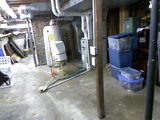

In [144]:
rgb_collection[number]

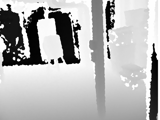

In [145]:
gt_depth_collection[number]

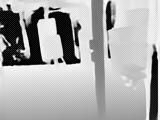

In [146]:
pred_depth_collection[number]